In [1]:
import sys
sys.path.append("..")


from nilearn import plotting
from nilearn.interfaces.fmriprep import load_confounds
from nilearn.interfaces.bids import get_bids_files
from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import zscore

from bold_dementia.connectivity.atlases import Atlas

ATLAS = "harvard-oxford"
SOFT = False # TODO Soft case

BIDSDIR = Path("/georges/memento/BIDS")

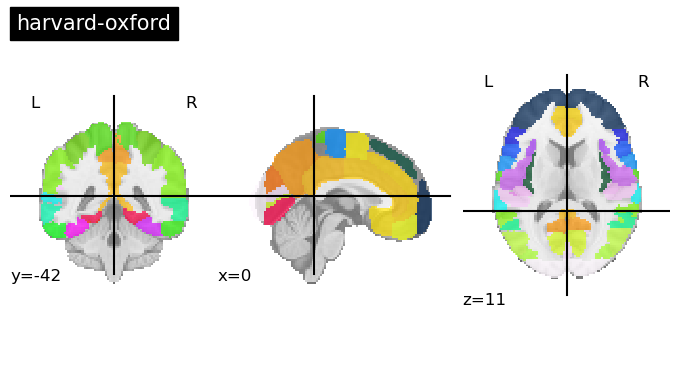

In [2]:
atlas = Atlas.from_name(ATLAS,SOFT)
atlas.plot()


In [3]:
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0/",
    "bold",
    sub_label="0001",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym")
    ],
)
fmri_path

['/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M000/func/sub-0001_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M024/func/sub-0001_ses-M024_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M048/func/sub-0001_ses-M048_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz']

In [8]:
confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}


In [9]:
masker = atlas.fit_masker(standardize=True, memory="/tmp/nilearn_cache", memory_level=2)
confounds, sample_mask = load_confounds(
    fmri_path,
    **confounds_strategy 
)

raw_ts = [masker.fit_transform(fmri) for fmri in fmri_path]

pre_parc = []
for fmri in fmri_path:
    c, s = load_confounds(
        fmri,
        **confounds_strategy,
        
    )
    pre_parc.append(
        masker.fit_transform(fmri, c, s)
    )

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:123: UserWarning: Persisting input arguments took 1.68s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  region_signals, aux = cache(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/joblib/memory.py:655: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  return self._cached_call(args, kwargs)[0]
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/maskers/base_masker.py:123: UserWarning: Persisting input arguments took 1.72s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  region

In [10]:

# TODO Scrubbing
post_parc = [clean(r, confounds=confounds, standardize="zscore_sample") for r in raw_ts]

/tmp/ipykernel_2896052/2679044726.py:2: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  post_parc = [clean(r, confounds=confounds, standardize="zscore_sample") for r in raw_ts]


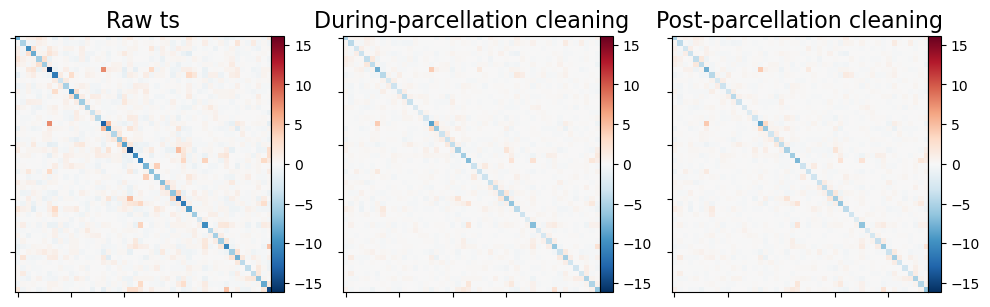

In [17]:
from bold_dementia.models.transformers import ListScaler

cm = ConnectivityMeasure(kind="precision") # TODO Precision?

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

cm.fit(raw_ts)
span = np.max(cm.mean_.flatten().__abs__())

plotting.plot_matrix(
    -cm.mean_,
    vmin=-span,
    vmax=span,
    axes=ax[0],
    title="Raw ts"
)

cm.fit(pre_parc)

plotting.plot_matrix(
    -cm.mean_,
    vmin=-span,
    vmax=span,
    axes=ax[1],
    title="During-parcellation cleaning"
)

cm.fit(post_parc)
plotting.plot_matrix(
    -cm.mean_,
    vmin=-span,
    vmax=span,
    axes=ax[2],
    title="Post-parcellation cleaning"
)



plotting.show()